In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, mode
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (9, 9)

## Data Wrangling

In [3]:
def getWhatsCookingData(jsonFile):
    """Takes a .json file and returns a dataframe whose columns are the cuisines(the targets)
    , and two columns with different ways of presenting the ingredients(the features).
    The memory used by the dataframe is well below 100 MB.
    In a previous version I used natural language processing, but it didn't improve the accuracy."""
    
    df = (pd
          .read_json(jsonFile)
          .set_index('id'))
    
    df['cuisine'] = (df['cuisine']
                     .astype('category'))
    
    df['ingredients_str'] = [' '.join(lists).strip() for lists in df['ingredients']]
    
    return df

In [4]:
traindf = getWhatsCookingData('train.json')

In [5]:
traindf.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 10259 to 2362
Data columns (total 3 columns):
cuisine            39774 non-null category
ingredients        39774 non-null object
ingredients_str    39774 non-null object
dtypes: category(1), object(2)
memory usage: 13.8 MB


In [6]:
traindf.head()

,cuisine,ingredients,ingredients_str
id,,,
10259,greek,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...
25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...
20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...
22213,indian,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt
13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...


## Exploratory Analysis

What are the different cuisines?

In [7]:
cuisineCounts = traindf['cuisine'].value_counts()

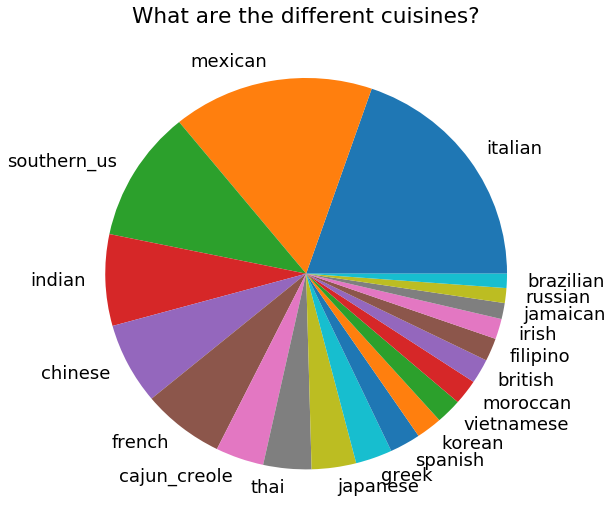

In [8]:
plt.figure()
plt.pie(cuisineCounts, labels = cuisineCounts.keys())
plt.title('What are the different cuisines?')
plt.show()

How many ingredients in each recipe?

In [9]:
ingredient_list_len = traindf['ingredients'].str.len()

In [10]:
stats_labels = ['mean', 'median', 'standard deviation', 'skew', 'kurtosis', 'mode']

In [11]:
def creates_stats_str(list_len):
    stats = [np.mean(list_len),
             np.median(list_len),
             np.std(list_len),
             skew(list_len),
             kurtosis(list_len),
             mode(list_len)[0][0]]
    stats_str = ('\n'.join([stats_labels[i] + ' = ' + str(np.round(stats[i], decimals = 1)) 
                             for i in range(len(stats_labels))]))
    return stats_str

In [12]:
desc_stats_str = creates_stats_str(ingredient_list_len)

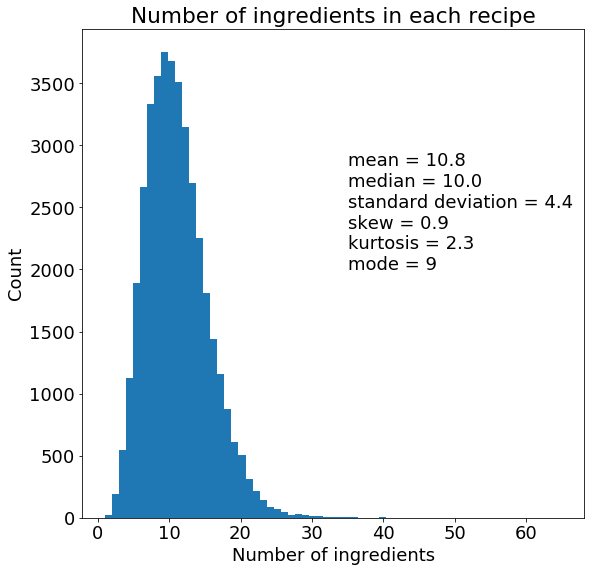

In [13]:
plt.figure()
plt.hist(ingredient_list_len, bins = np.max(ingredient_list_len))
plt.xlabel('Number of ingredients')
plt.ylabel('Count')
plt.title('Number of ingredients in each recipe')
plt.text(35, 2000, desc_stats_str)
plt.show()

Most common ingredients:

In [14]:
def ingredients_commonness(column):
    se = (column
          .apply(pd.Series)
          .stack()
          .reset_index(drop = True)
          .astype('category'))
    return (len(se.unique()), se.value_counts())

In [15]:
(ingred_U, ingred_VC) = ingredients_commonness(traindf['ingredients'])

In [16]:
def ingredient_word_cloud(ingredient_values):
    wclist = [(ingredient, ingredient_values[ingredient].astype(float)) for ingredient in ingredient_values.keys()]
    wc = WordCloud().generate_from_frequencies(wclist)
    default_colors = wc.to_array()
    plt.figure()
    plt.imshow(default_colors, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('Most common ingredients')
    plt.show()

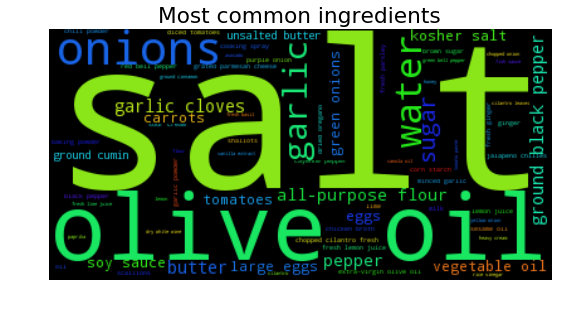

In [17]:
ingredient_word_cloud(ingred_VC)

## Data Preprocessing, Modeling and Validating

In [18]:
Tfidf_vec = TfidfVectorizer(stop_words = 'english',
                            ngram_range = ( 1 , 1 ),
                            analyzer = "word",
                            max_df = 0.6,
                            binary = False,
                            token_pattern = r'\w+',
                            sublinear_tf = False)

In [19]:
X = (Tfidf_vec
     .fit_transform(traindf['ingredients_str'])
     .todense())

In [20]:
y = traindf['cuisine']

In [21]:
classifier = LinearSVC(C = 0.80, penalty = "l2", dual = False)

In [22]:
cross_val_score(classifier, X, y, cv = 3, scoring = 'accuracy')

array([ 0.78662444,  0.78580587,  0.78720193])

In [23]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2)

In [24]:
classifier2 = classifier.fit(X_train, y_train)

In [25]:
y_predict = classifier2.predict(X_test)

In [26]:
conf_mat = confusion_matrix(y_test, y_predict)

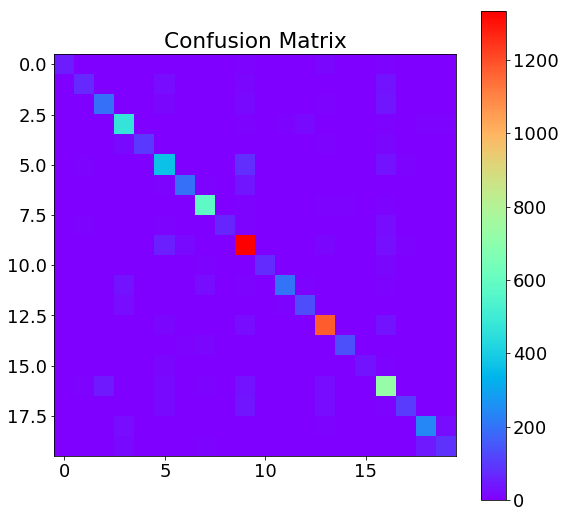

In [27]:
plt.imshow(conf_mat, cmap = plt.cm.rainbow, interpolation = 'nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.show()

In [28]:
y_score = classifier2.decision_function(X_test)

In [29]:
Count_vec = CountVectorizer()

In [30]:
y_test_vec = (Count_vec
              .fit_transform(y_test)
              .toarray())

In [31]:
n_classes = len(traindf['cuisine'].cat.categories)

In [32]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_vec[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [33]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_vec.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [34]:
def ROCplot(index, color):
    plt.figure()
    plt.plot(fpr[index], tpr[index], color = color, 
             lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc[index])
    plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve %s' % traindf['cuisine'].cat.categories[index])
    plt.legend(loc = 'lower right')
    plt.show()

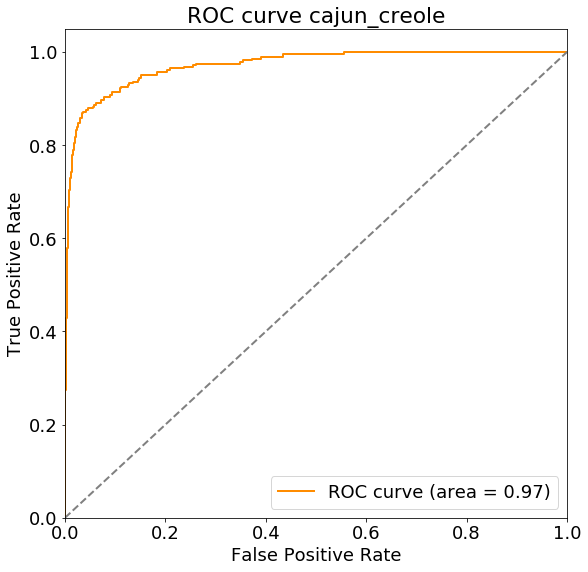

In [35]:
ROCplot(2, 'darkorange')

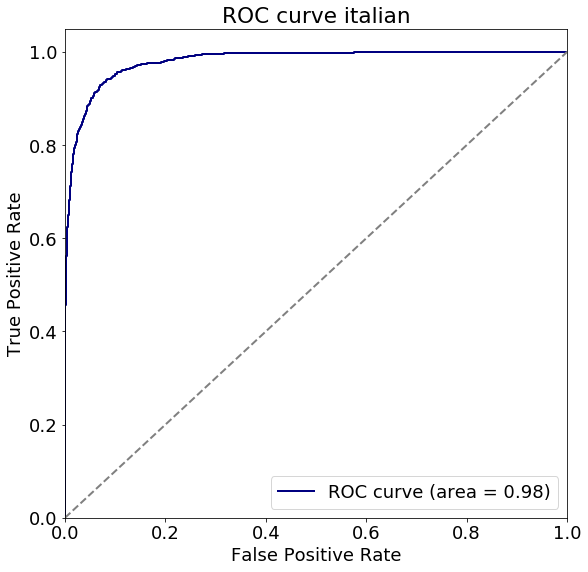

In [36]:
ROCplot(9, 'navy')